In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from scripts.TrainMLModels import read_json, make_folder

# EXP 1: Comparing to baselines: no intervention and multi-model

## Read results from disc

In [3]:
seeds = [1, 12345, 6, 2211, 15]
datasets = ['cardio', 'bank', 'meps16', 'lsac', 'credit', 'ACSE', 'ACSP', 'ACSM', 'ACSI'] # for MCC

In [4]:
# extracting evalaution results from different methods with multiple models
res_path = 'intermediate/models/'
set_suffix = 'S_1'


group_eval_metrics = ['AUC', 'ACC', 'SR', 'BalAcc']
overall_metrics = ['BalAcc', 'DI', 'EQDiff', 'AvgOddsDiff', 'SPDiff', 'FPRDiff', 'FNRDiff', 'ERRDiff']

methods = ['MCC-MIN', 'MCC-W1', 'MCC-W2', 'SEP', 'ORIG']

eval_path = 'intermediate/evals/'
eval_file = 'Data{}-run{}-{}-{}.csv'.format(len(datasets), len(seeds), set_suffix, 'multi')


all_eval_files = list(filter(lambda x: not os.path.isdir(os.path.join(eval_path, x)), os.listdir(eval_path)))
if not eval_file in all_eval_files:
    multi_df = pd.DataFrame(columns=['data', 'seed', 'method', 'group', 'metric', 'value'])

    for data_name in datasets:
        for seed in seeds:
            eval_res = read_json('{}eval-{}-{}-mcc.json'.format(res_path+data_name+'/', seed, set_suffix))
            for method in methods:
#                 print(eval_res[method])
                
                for group in ['all', 'G0', 'G1']:
                    base = [data_name, seed, method, group]
                    for metric_i in group_eval_metrics:
                        multi_df.loc[multi_df.shape[0]] = base + [metric_i, eval_res[method][group][metric_i]]
                for metric_i in overall_metrics:
                    multi_df.loc[multi_df.shape[0]] = [data_name, seed, method, 'all'] + [metric_i, eval_res[method]['all'][metric_i]]

    multi_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))
else:
    multi_df = pd.read_csv(eval_path+eval_file)
    print('Read evaluation results from {}'.format(eval_path+eval_file))
    

Save evaluation results at intermediate/evals/Data9-run5-S_1-multi.csv


In [5]:
multi_df.head(10)

,data,seed,method,group,metric,value
0,cardio,1,MCC-MIN,all,AUC,0.597000
1,cardio,1,MCC-MIN,all,ACC,0.599000
2,cardio,1,MCC-MIN,all,SR,0.340952
3,cardio,1,MCC-MIN,all,BalAcc,0.597401
4,cardio,1,MCC-MIN,G0,AUC,0.594000
5,cardio,1,MCC-MIN,G0,ACC,0.629000
6,cardio,1,MCC-MIN,G0,SR,0.297330
7,cardio,1,MCC-MIN,G0,BalAcc,0.594427
8,cardio,1,MCC-MIN,G1,AUC,0.587000
9,cardio,1,MCC-MIN,G1,ACC,0.561000


In [7]:
# extracting evaluation results from methods with a single model

methods = ['scc', 'scc', 'scc', 'omn', 'kam']
bases = ['one', 'kam', 'omn', 'one', 'one']

eval_file = 'Data{}-run{}-{}-{}.csv'.format(len(datasets), len(seeds), set_suffix, 'single')


all_eval_files = list(filter(lambda x: not os.path.isdir(os.path.join(eval_path, x)), os.listdir(eval_path)))
if not eval_file in all_eval_files:
    single_df = pd.DataFrame(columns=['data', 'seed', 'method', 'group', 'metric', 'value'])

    for data_name in datasets:
        cur_dir = 'intermediate/models/' + data_name +'/'
        for seed in seeds:
            for method, weight_base in zip(methods, bases):
                eval_res = read_json('{}eval-{}-{}-{}-{}.json'.format(cur_dir, seed, set_suffix, method, weight_base))
                method_eval = '{}-{}'.format(method.upper(), weight_base.upper())
                for group in ['all', 'G0', 'G1']:
                    base = [data_name, seed, method_eval, group]
                    for metric_i in group_eval_metrics:
                        single_df.loc[single_df.shape[0]] = base + [metric_i, eval_res[method.upper()][group][metric_i]]
                for metric_i in overall_metrics:
                    single_df.loc[single_df.shape[0]] = [data_name, seed, method_eval, 'all'] + [metric_i, eval_res[method.upper()]['all'][metric_i]]

    single_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))
else:
    single_df = pd.read_csv(eval_path+eval_file)
    print('Read evaluation results from {}'.format(eval_path+eval_file))
    
    

Save evaluation results at intermediate/evals/Data4-run5-S_1-single.csv


In [6]:
# for visualization change the values to be consistent with the order that higher is better
def normalize_fairness_measures(x):
    if 'Diff' in x.iloc[0]: # difference change to 1-abs(x)
        return 1-abs(x.iloc[1])
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return min(x.iloc[1], 1/x.iloc[1])
        else:
            return x.iloc[1]
    else:# other metrics
        return x.iloc[1]
def add_vis_flag(x):
    if 'Diff' in x.iloc[0]: # difference change to 1-abs(x)
        if x.iloc[1] < 0: 
            return 0
        else: # G0 has better outcome
            return 1
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return 1
        else:
            return 0
    else:# other metrics
        return 0


In [7]:
# merge and normalize results 
eval_file = 'Data{}-run{}-{}.csv'.format(len(datasets), len(seeds), set_suffix)

all_eval_files = list(filter(lambda x: not os.path.isdir(os.path.join(eval_path, x)), os.listdir(eval_path)))
if not eval_file in all_eval_files:
#     eval_df = pd.concat([multi_df, single_df])
#     eval_df.reset_index(drop=True, inplace=True)
    eval_df = multi_df.copy()
    eval_df['norm_value'] = eval_df[['metric', 'value']].apply(lambda x: normalize_fairness_measures(x), axis=1)
    eval_df['norm_flag'] = eval_df[['metric', 'value']].apply(lambda x: add_vis_flag(x), axis=1)
    
    eval_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))
else:
    eval_df = pd.read_csv(eval_path+eval_file)
    print('Read evaluation results from {}'.format(eval_path+eval_file))

Save evaluation results at intermediate/evals/Data9-run5-S_1.csv


In [8]:
eval_df.head()

,data,seed,method,group,metric,value,norm_value,norm_flag
0,cardio,1,MCC-MIN,all,AUC,0.597000,0.597000,0
1,cardio,1,MCC-MIN,all,ACC,0.599000,0.599000,0
2,cardio,1,MCC-MIN,all,SR,0.340952,0.340952,0
3,cardio,1,MCC-MIN,all,BalAcc,0.597401,0.597401,0
4,cardio,1,MCC-MIN,G0,AUC,0.594000,0.594000,0


In [50]:
# metric = 'DI'
# seeds = [88, 121, 433, 500, 1121, 50]
# for name in datasets:
#     for seed in seeds:
# #         print(single_df.query('data=="{}" and seed=={} and setting=="C" and group=="all" and metric=="{}"'.format(name, seed, metric)), '\n')
# #         print(eval_df.query('data=="{}" and seed=={} and setting=="SingleCC" and group=="all" and metric=="{}"'.format(name, seed, metric)))
# #         print('\n')
        
# #         print(multi_df.query('data=="{}" and seed=={} and setting=="F" and group=="all" and metric=="{}"'.format(name, seed, metric)))
# #         print(eval_df.query('data=="{}" and seed=={} and setting=="MultiCC" and group=="all" and metric=="{}"'.format(name, seed, metric)))
# #         print('\n')
        
#         print(multi_df.query('data=="{}" and seed=={} and setting=="A" and group=="all" and metric=="{}"'.format(name, seed, metric)))
#         print(eval_df.query('data=="{}" and seed=={} and setting=="no intervention" and group=="all" and metric=="{}"'.format(name, seed, metric)))
        
#         print('\n\n')

## Draw barplots

In [57]:
def bar_plots(df, vis_name, vis_datasets, vis_metric, vis_settings, 
              legend_names=None, font_label=26, font_legend=18, 
              colors=['#ffffff', '#fffacd', '#3cb371','#20603d', '#0e6670'], bg_color = '#f3f3f3', 
              x_ticks=None, y_label=None, x_label=None, legend=True, legend_col=5, save_to_disc=True, 
              plot_path = 'intermediate/evals/plots/'):
    
    fig, ax = plt.subplots(1, figsize=(10, 4), dpi=200)
    input_df = df.copy()
    bar_mean = []
    bar_std = []
    dash_filling = []
    x_bars = []
    ind = 0
    for off_i, name in enumerate(vis_datasets):
        vis_df = input_df[(input_df['data']==name) & (input_df['metric']==vis_metric) & (input_df['group']=='all')].copy()
        for setting_i in vis_settings:
            set_df = vis_df[vis_df['method']==setting_i]
            y_values = np.array(set_df['norm_value'])
            n_reverse = sum(np.array(set_df['norm_flag']))
            if n_reverse > int(len(y_values) * 0.9): # majoirty of cases in which G0 has better outcomes
                dash_filling.append(True)
            else:
                dash_filling.append(False)
            
            bar_mean.append(np.mean(y_values))
            bar_std.append(np.std(y_values))
            x_bars.append(ind+off_i*2)
                
            ind += 0.83
    bplot = ax.bar(x_bars, bar_mean, yerr=bar_std)
    print('-->', vis_metric, bar_mean)
    
    n_bars = len(vis_settings)
    for idx, patch in enumerate(bplot):
        patch.set_facecolor(colors[idx % n_bars])
        
        if dash_filling[idx]:
            patch.set_hatch('//')
            patch.set_edgecolor("#cb4154")
        else:
            patch.set_edgecolor("black")
    if legend_names:
        legends = legend_names
    else:
        legends = vis_settings
    # add labels for settings 
    for idx, setting_i, color_i, legend_i in zip(range(len(vis_settings)), vis_settings, colors, legends):
        ax.bar(-2, 1, ec='black', fc=color_i, label=legend_i)

    ax.set_facecolor(bg_color)
    ax.yaxis.grid(True)
    plt.xlim([-1, max(x_bars)+1])
    plt.xticks([(x-1)*5.4+0.8 for x in range(1, len(vis_datasets)+1)])
    if x_ticks:
        locs, labels=plt.xticks();
        plt.xticks(locs, x_ticks, horizontalalignment='center', fontsize=font_label-10, rotation=0);

    plt.ylim([0.0, 1.0])
    plt.yticks(fontsize=font_label);

    if y_label:
        plt.ylabel(y_label, fontsize=font_label)

    if x_label:
        plt.xlabel(x_label, fontsize=font_label)

    if legend:
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=legend_col, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_label-7)

    if save_to_disc:
        plt.savefig(plot_path+vis_name+'_'+vis_metric+'.png', bbox_inches="tight")
    print('Bar plot is saved at ', plot_path+vis_name+'_'+vis_metric+'.png')

--> BalAcc [0.637970026096373, 0.6380294804599063, 0.6003338602105208, 0.6167378799174956, 0.7538572188365417, 0.7266252448606046, 0.7160959689765072, 0.7156500511537252, 0.7520803462088113, 0.7440793293668918, 0.7179763386696638, 0.7327526620098799, 0.6613594828127506, 0.6478248530243311, 0.6365038411075604, 0.6413896029683126, 0.6139294214189098, 0.5505917855121417, 0.5505741215502782, 0.5132772033984111, 0.7706500679458342, 0.7676096817432099, 0.747232048683335, 0.7586241104742276, 0.6474821515230279, 0.6439417558616342, 0.6291742205522622, 0.6251679642790535, 0.6136310707467627, 0.5952068757543489, 0.5924126595470118, 0.6029013983213882, 0.676859446289536, 0.6661204065920391, 0.6364716726988486, 0.6561390042644932]
Bar plot is saved at  intermediate/evals/plots/mcc/mcc_BalAcc.png


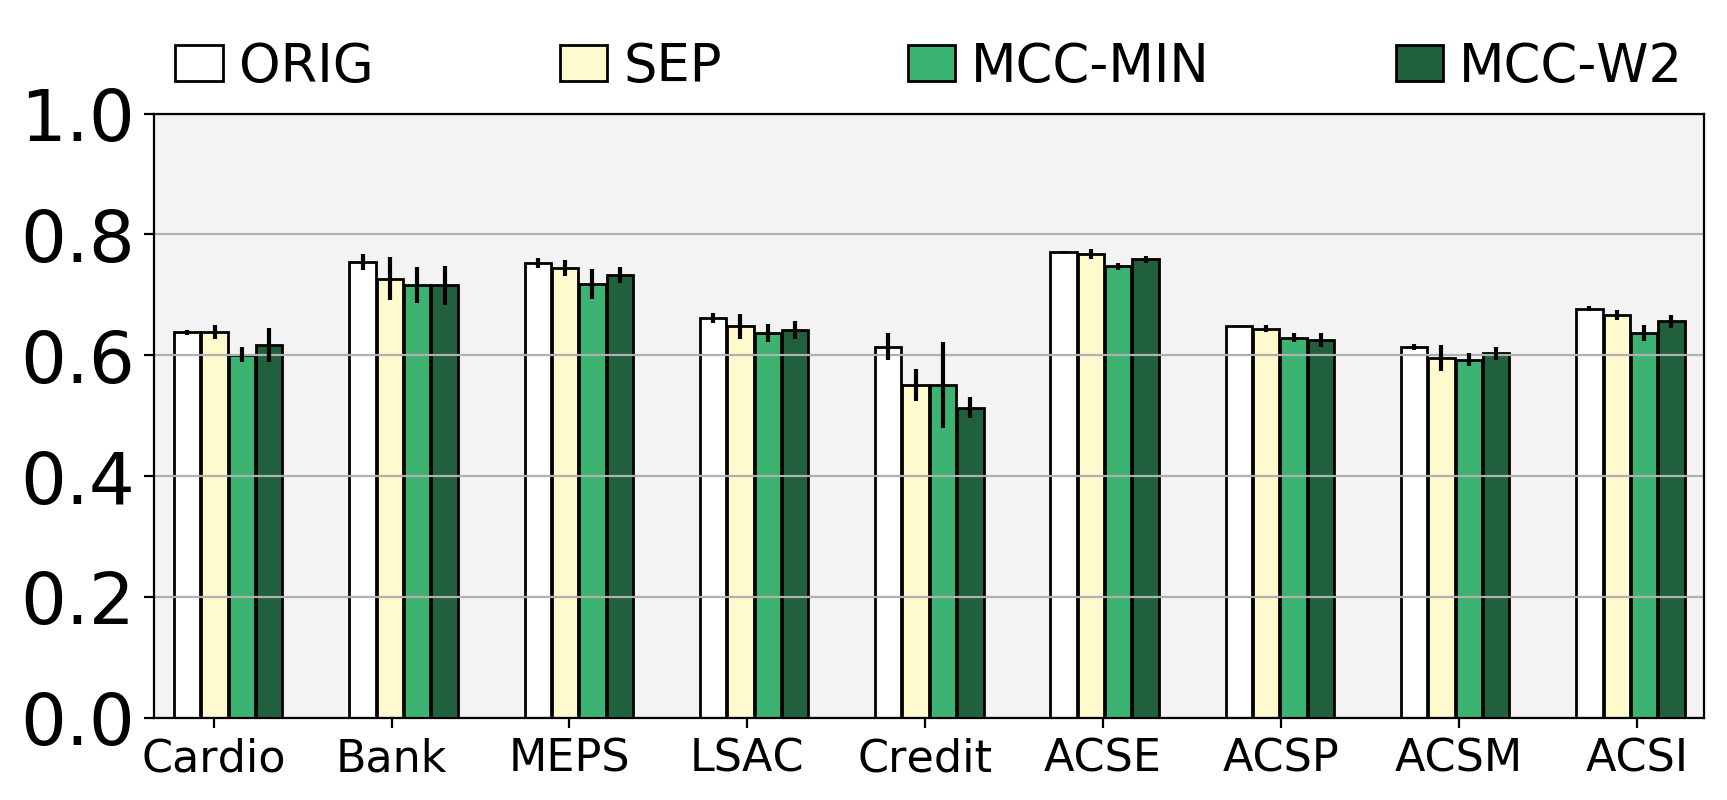

In [58]:
plot_path = 'intermediate/evals/plots/'
exp_name = 'mcc'

# initiate a new folder for the plots
# exp_path = plot_path+exp_name+'/'
exp_path = plot_path+exp_name+'/'
make_folder(exp_path)



exp_settings = ['ORIG', 'SEP', 'MCC-MIN', 'MCC-W2'] #'MCC-W1', 
# exp_settings = ['ORIG', 'OMN-ONE', 'KAM-ONE', 'SCC-KAM']

# exp_settings = ['OMN-ONE', 'SCC-OMN', 'KAM-ONE', 'SCC-KAM']

exp_datasets = ['cardio', 'bank', 'meps16', 'lsac', 'credit', 'ACSE', 'ACSP', 'ACSM', 'ACSI']
exp_ticks = ['Cardio', 'Bank', 'MEPS', 'LSAC', 'Credit', 'ACSE', 'ACSP', 'ACSM', 'ACSI']

exp_metric = 'BalAcc'
bar_plots(eval_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


--> DI [0.2752742014286458, 0.29362186240068455, 0.764086069107732, 0.788974583428805, 0.46255494648306544, 0.5268864898715606, 0.7213204818983899, 0.7267855621631487, 0.35047723539699244, 0.3965893686663721, 0.6844400445915915, 0.6308319513675595, 0.49979535325763236, 0.4817316054838855, 0.556198080440379, 0.5729093703445768, 0.0014908129911898366, 0.1623522185653184, 0.6644140779023686, 0.3374127141496056, 0.7722093638554972, 0.7710139092474445, 0.8039350730743239, 0.8078059003420408, 0.42461889920588713, 0.6243021013772556, 0.8013047431784399, 0.8019113387980671, 0.8716683474985853, 0.7791154234054878, 0.8549540072299951, 0.8589825014318277, 0.6956809224798906, 0.6564042491474995, 0.8804995024498284, 0.8597895233959244]
Bar plot is saved at  intermediate/evals/plots/mcc/mcc_DI.png


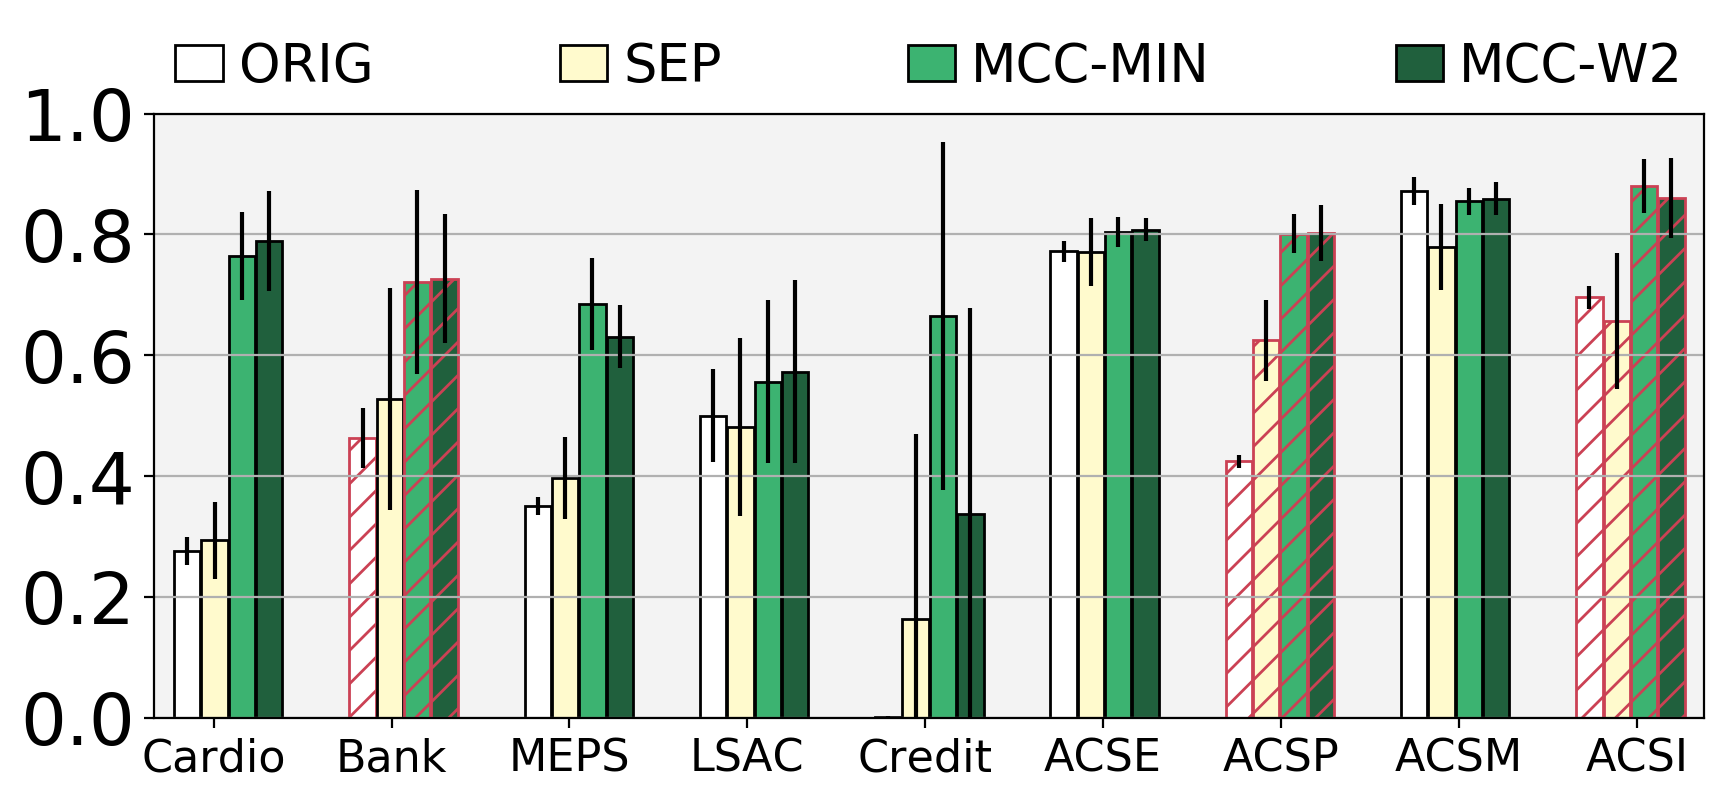

In [59]:
exp_metric = 'DI'
bar_plots(eval_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


--> FPRDiff [0.3874192953080895, 0.37945608483042503, 0.9213509749474842, 0.9104506234236751, 0.6305027257713818, 0.7373292967600189, 0.8893956704245889, 0.8962860558621537, 0.7172659485348717, 0.7648637777570537, 0.9184097319166765, 0.910058494386574, 0.6510469403503942, 0.6530963289986843, 0.7156821156103803, 0.744345731938628, 0.7109674243428267, 0.5073943760902659, 0.9498231031002214, 0.9983787654440718, 0.939776745109574, 0.9257436059782602, 0.9288401870518577, 0.9404380614580138, 0.5781780589011294, 0.7633221501240441, 0.916019773900824, 0.9294968630213878, 0.8519818095650257, 0.763200074795158, 0.8194303355149584, 0.8240428093285086, 0.7883412674506831, 0.7394414222358737, 0.9250930397133075, 0.922564101852301]
Bar plot is saved at  intermediate/evals/plots/mcc/mcc_FPRDiff.png


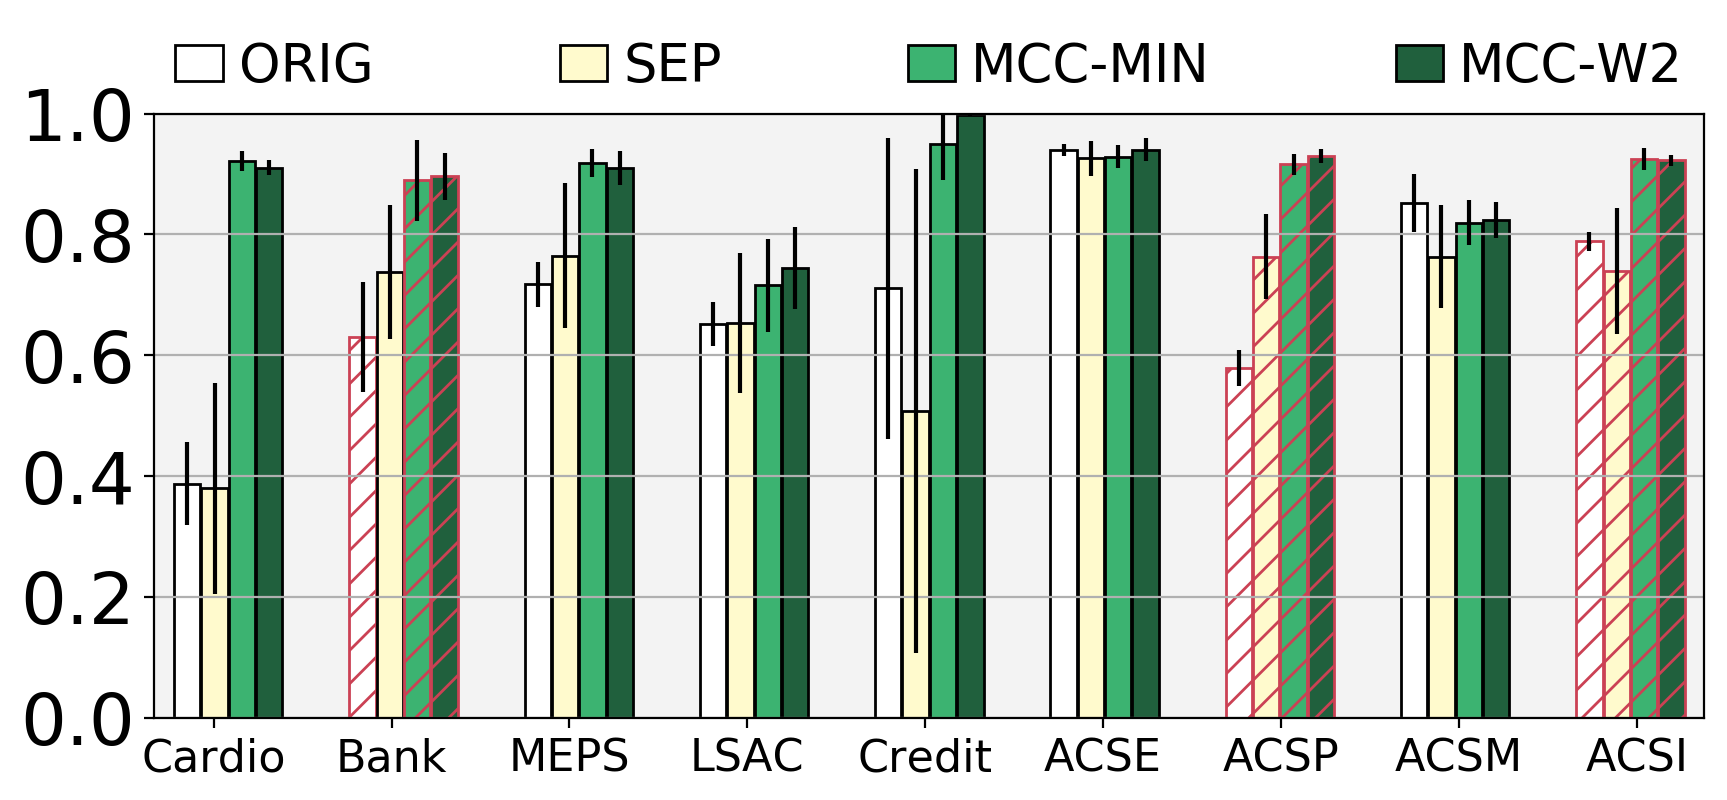

In [60]:
exp_metric = 'FPRDiff'
bar_plots(eval_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


--> FNRDiff [0.49093581609073633, 0.48928373374280565, 0.9494032293299426, 0.9581041911533376, 0.8399653393323788, 0.776867019748408, 0.9013081306621273, 0.9039022807149752, 0.758612701099285, 0.8171726812534382, 0.9435933388775343, 0.9451207734749977, 0.689396450431339, 0.7060537327349554, 0.7825152958180799, 0.802937267884011, 0.5045193550729998, 0.4671963344109978, 0.9139595103635767, 0.9820028297852247, 0.8856177990542564, 0.9162165516538628, 0.9629106425004952, 0.9490033855677507, 0.6414031481081477, 0.7946597055247524, 0.9013448996563564, 0.8970835997439528, 0.9397464895187845, 0.8582820031128481, 0.9283066443335961, 0.9245747059638824, 0.8830024919875925, 0.8615250626315291, 0.9760067690793257, 0.9793126918258309]
Bar plot is saved at  intermediate/evals/plots/mcc/mcc_FNRDiff.png


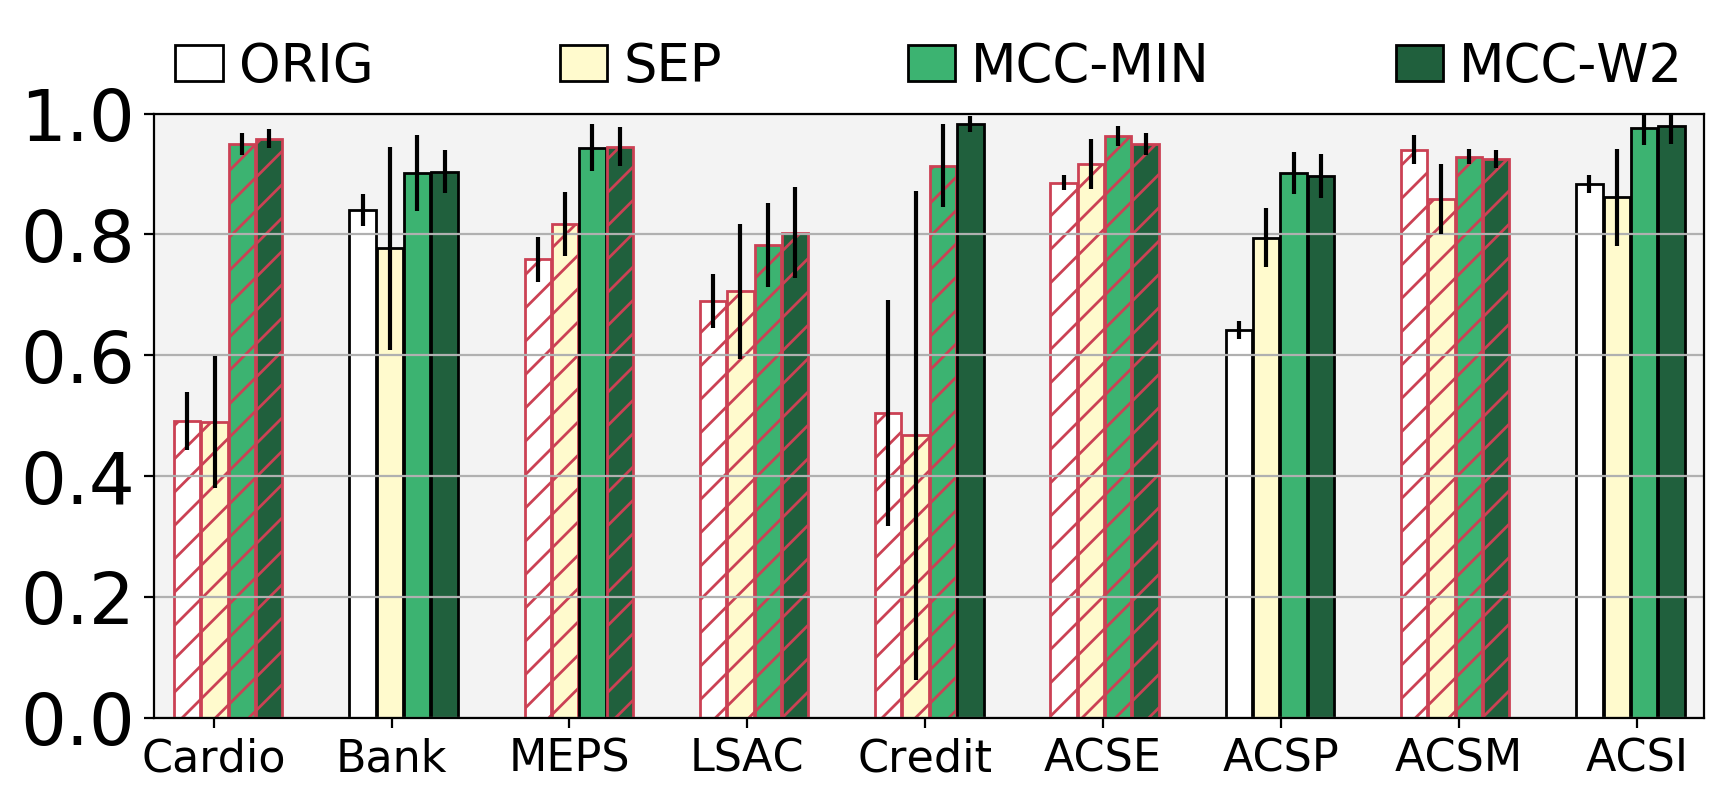

In [61]:
exp_metric = 'FNRDiff'
bar_plots(eval_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


--> ERRDiff [0.9705999999999999, 0.9673999999999999, 0.9468, 0.9432, 0.74, 0.8366, 0.9294, 0.9385999999999999, 0.8122, 0.8301999999999999, 0.9432, 0.9269999999999999, 0.8594000000000002, 0.8756, 0.9174000000000001, 0.9263999999999999, 0.7246, 0.54, 0.9388, 0.9532000000000002, 0.9804, 0.9942, 0.9763999999999999, 0.9892, 0.9393999999999998, 0.9844000000000002, 0.9596, 0.9583999999999999, 0.9805999999999999, 0.9465999999999999, 0.986, 0.9816, 0.9335999999999999, 0.9136000000000001, 0.9876000000000001, 0.982]
Bar plot is saved at  intermediate/evals/plots/mcc/mcc_ERRDiff.png


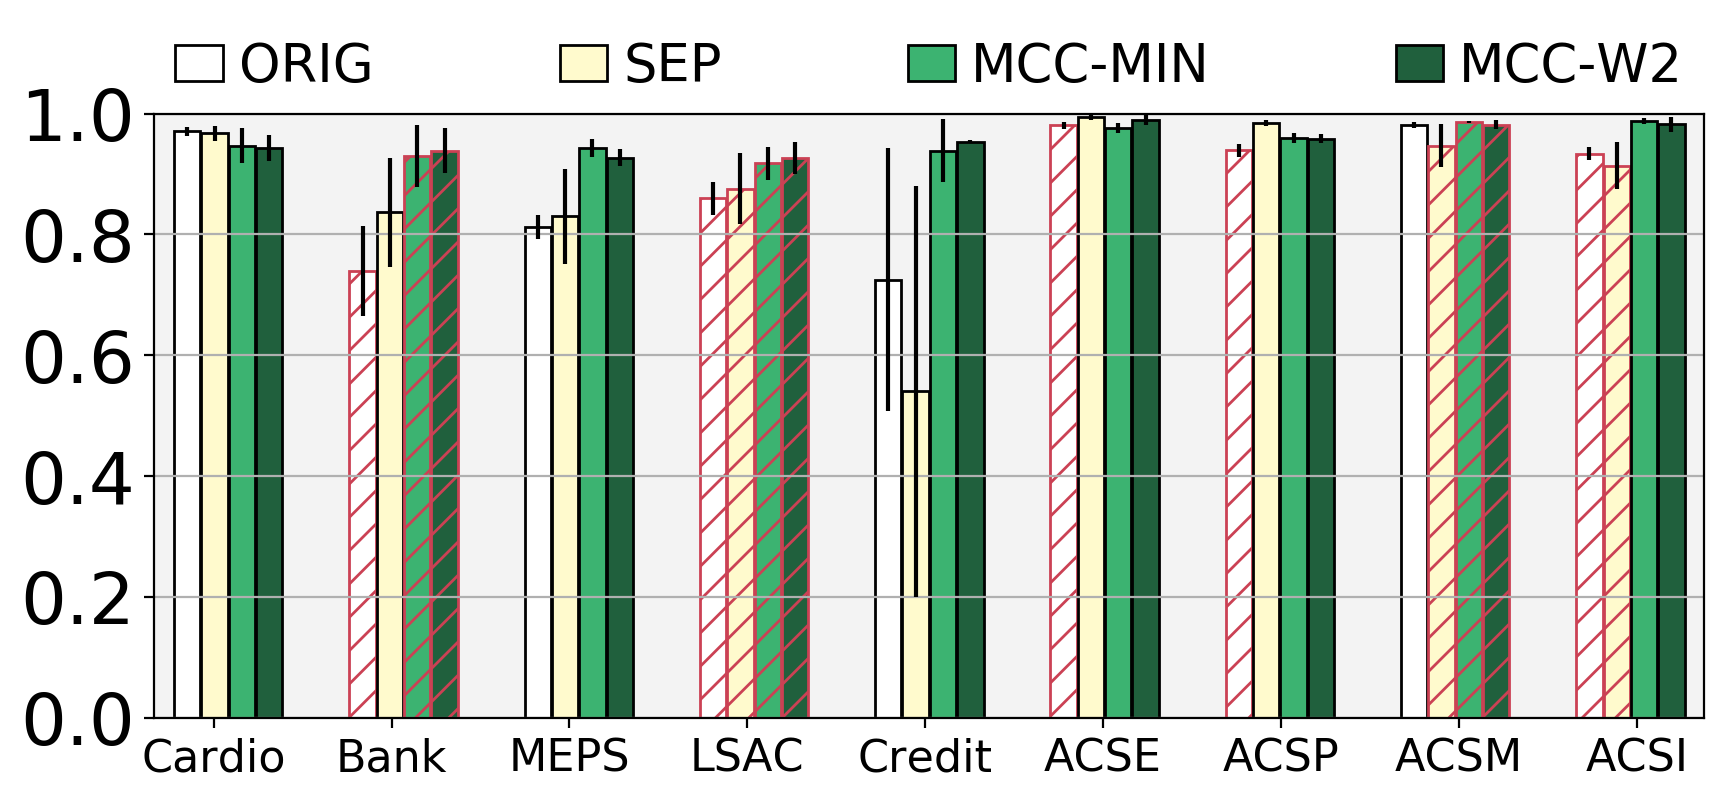

In [62]:
exp_metric = 'ERRDiff'
bar_plots(eval_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


--> EQDiff [0.49093581609073633, 0.48928373374280565, 0.9494032293299426, 0.9581041911533376, 0.8399653393323788, 0.776867019748408, 0.9013081306621273, 0.9039022807149752, 0.758612701099285, 0.8171726812534382, 0.9435933388775343, 0.9451207734749977, 0.689396450431339, 0.7060537327349554, 0.7825152958180799, 0.802937267884011, 0.5045193550729998, 0.4671963344109978, 0.9139595103635767, 0.9820028297852247, 0.8856177990542562, 0.9162165516538627, 0.9629106425004952, 0.9490033855677507, 0.6414031481081477, 0.7946597055247524, 0.9013448996563564, 0.8970835997439528, 0.9397464895187847, 0.8582820031128481, 0.9283066443335961, 0.9245747059638824, 0.8830024919875925, 0.8615250626315291, 0.9760067690793257, 0.9793126918258309]
Bar plot is saved at  intermediate/evals/plots/mcc/mcc_EQDiff.png


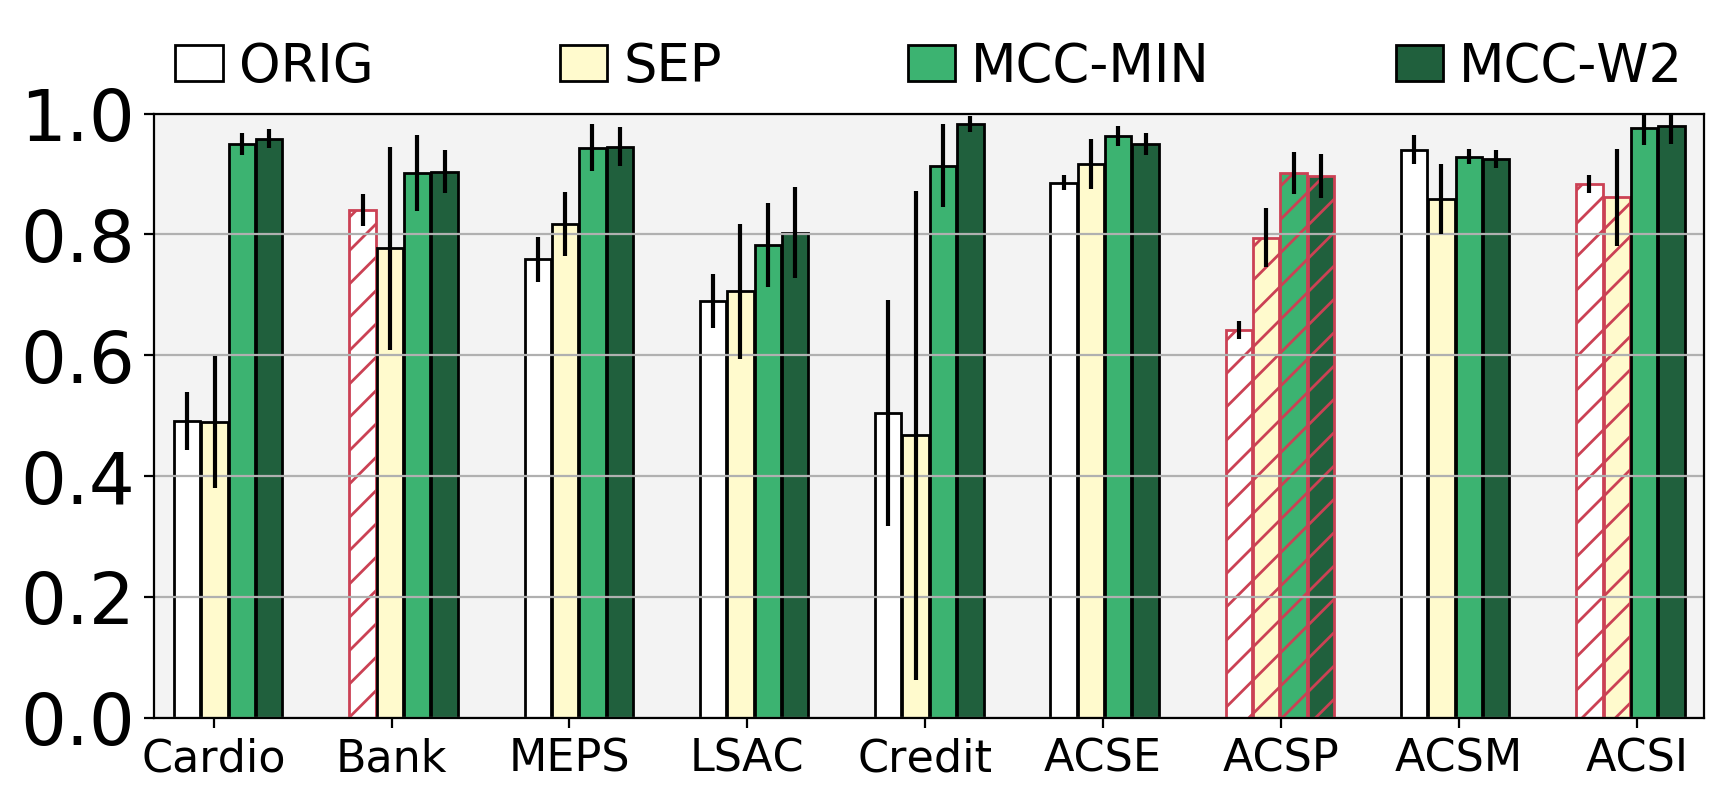

In [63]:
exp_metric = 'EQDiff'
bar_plots(eval_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


--> AvgOddsDiff [0.4391775556994129, 0.4343699092866153, 0.9353771021387134, 0.9342774072885064, 0.7352340325518804, 0.7570981582542134, 0.902342794717768, 0.9157158419197856, 0.7379393248170782, 0.7910182295052459, 0.9350581287429659, 0.927589633930786, 0.6702216953908666, 0.6795750308668198, 0.7490987057142301, 0.7736414999113194, 0.6077433897079132, 0.4873673498056877, 0.9398977775330453, 0.9904923010021782, 0.9126972720819152, 0.9209800788160614, 0.9458754147761764, 0.9447207235128822, 0.6097906035046385, 0.7789909278243983, 0.90868233677859, 0.9132902313826703, 0.8958641495419052, 0.8107410389540031, 0.8738684899242773, 0.8743087576461956, 0.8356718797191378, 0.8004832424337014, 0.9520975478638831, 0.9518354429713887]
Bar plot is saved at  intermediate/evals/plots/mcc/mcc_AvgOddsDiff.png


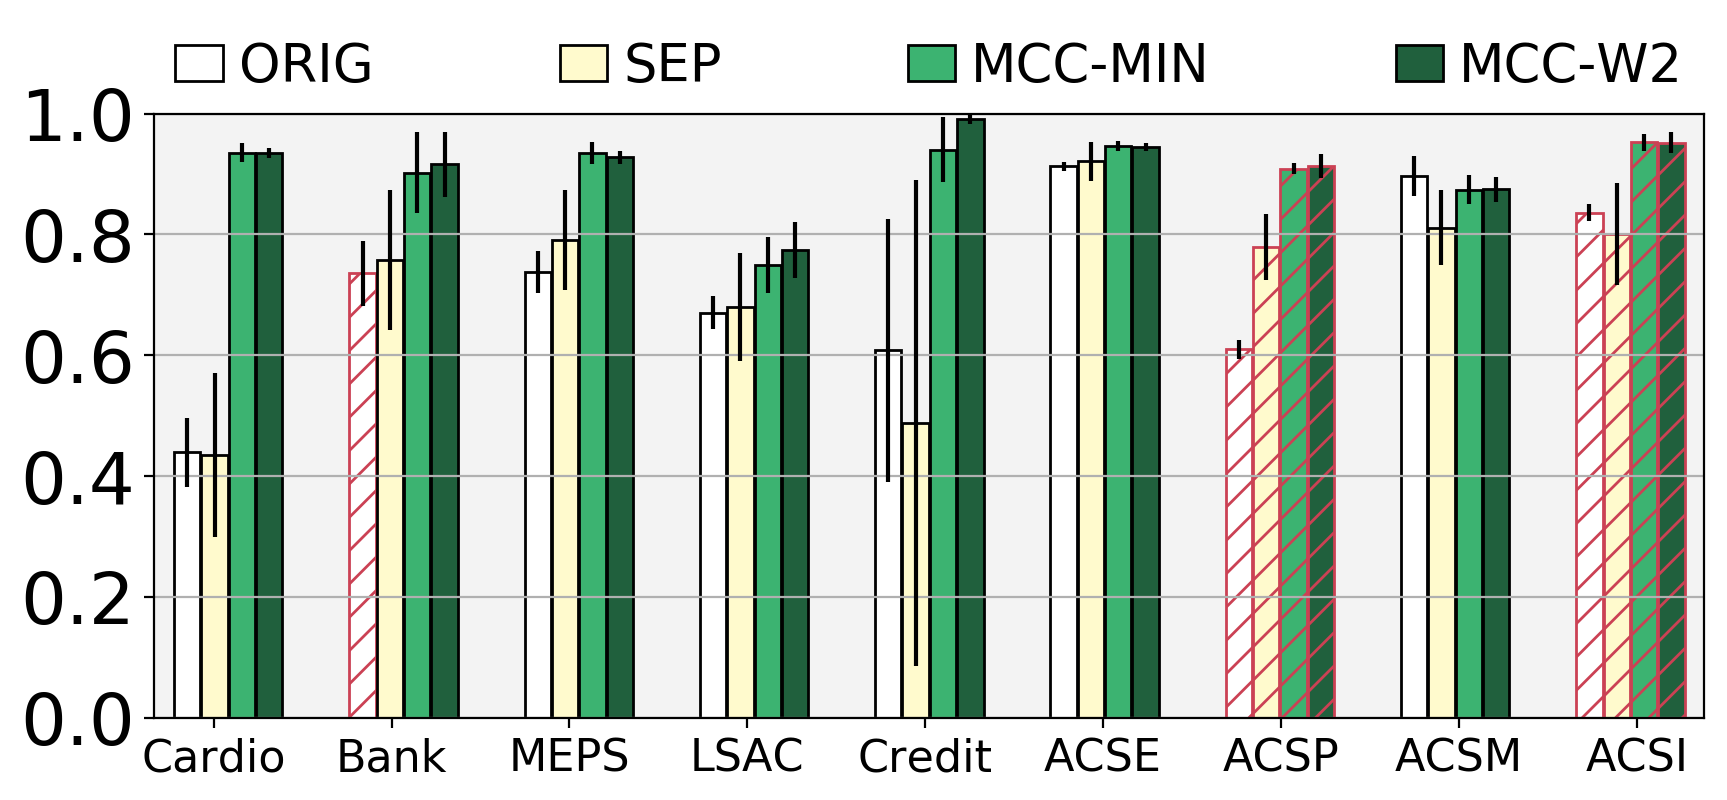

In [64]:
exp_metric = 'AvgOddsDiff'
bar_plots(eval_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)
